In [1]:
%%capture
pip install jumpmodels

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from jumpmodels.utils import filter_date_range
from jumpmodels.jump import JumpModel

In [3]:
data = yf.Ticker('SPY').history(period='max')
data.index = data.index.tz_localize(None)
log_ret = data.Close.apply(np.log).diff()
feat_dict = {}
hls = [5, 20, 60]
for hl in hls:
        # Feature 1: EWM-ret
        feat_dict[f"ret_{hl}"] = log_ret.ewm(halflife=hl).mean()
        # Feature 2: log(EWM-DD)
        DD = log_ret.apply(lambda x: min(x,0)).pow(2).ewm(halflife=hl).mean().pow(0.5)
        feat_dict[f"DD-log_{hl}"] = np.log(DD)
        # Feature 3: EWM-Sortino-ratio = EWM-ret/EWM-DD
        feat_dict[f"sortino_{hl}"] = feat_dict[f"ret_{hl}"].div(DD)
X = pd.DataFrame(feat_dict)

In [4]:
train_start, test_start = "2005-1-1", "2020-1-1"
# Filter dates
X_train = filter_date_range(X, start_date=train_start, end_date=test_start)
X_test = filter_date_range(X, start_date=test_start)
# Print time split
train_start, train_end = X_train.index[[0, -1]]
test_start, test_end = X_test.index[[0, -1]]
print("Training starts at:", train_start, "and ends at:", train_end)
print("Testing starts at:", test_start, "and ends at:", test_end)

Training starts at: 2005-01-03 00:00:00 and ends at: 2019-12-31 00:00:00
Testing starts at: 2020-01-02 00:00:00 and ends at: 2025-02-03 00:00:00


In [5]:
# Preprocessing
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
clipper = DataClipperStd(mul=3.)
scalar = StandardScalerPD()
# Fit on training data
X_train_processed = scalar.fit_transform(clipper.fit_transform(X_train))
# Transform the test data
X_test_processed = scalar.transform(clipper.transform(X_test))

In [6]:
# Set the jump penalty
jump_penalty=50.
# Initlalize a JM instance
jm = JumpModel(n_components=2, jump_penalty=jump_penalty, cont=False, )
# Fit data
jm.fit(X_train_processed, log_ret, sort_by="cumret")

JumpModel(jump_penalty=50.0)

In [8]:
# Disable Latex
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

[Text(0.5, 1.0, 'In-Sample Fitted Regimes by the JM ($\\lambda$=50.0)')]

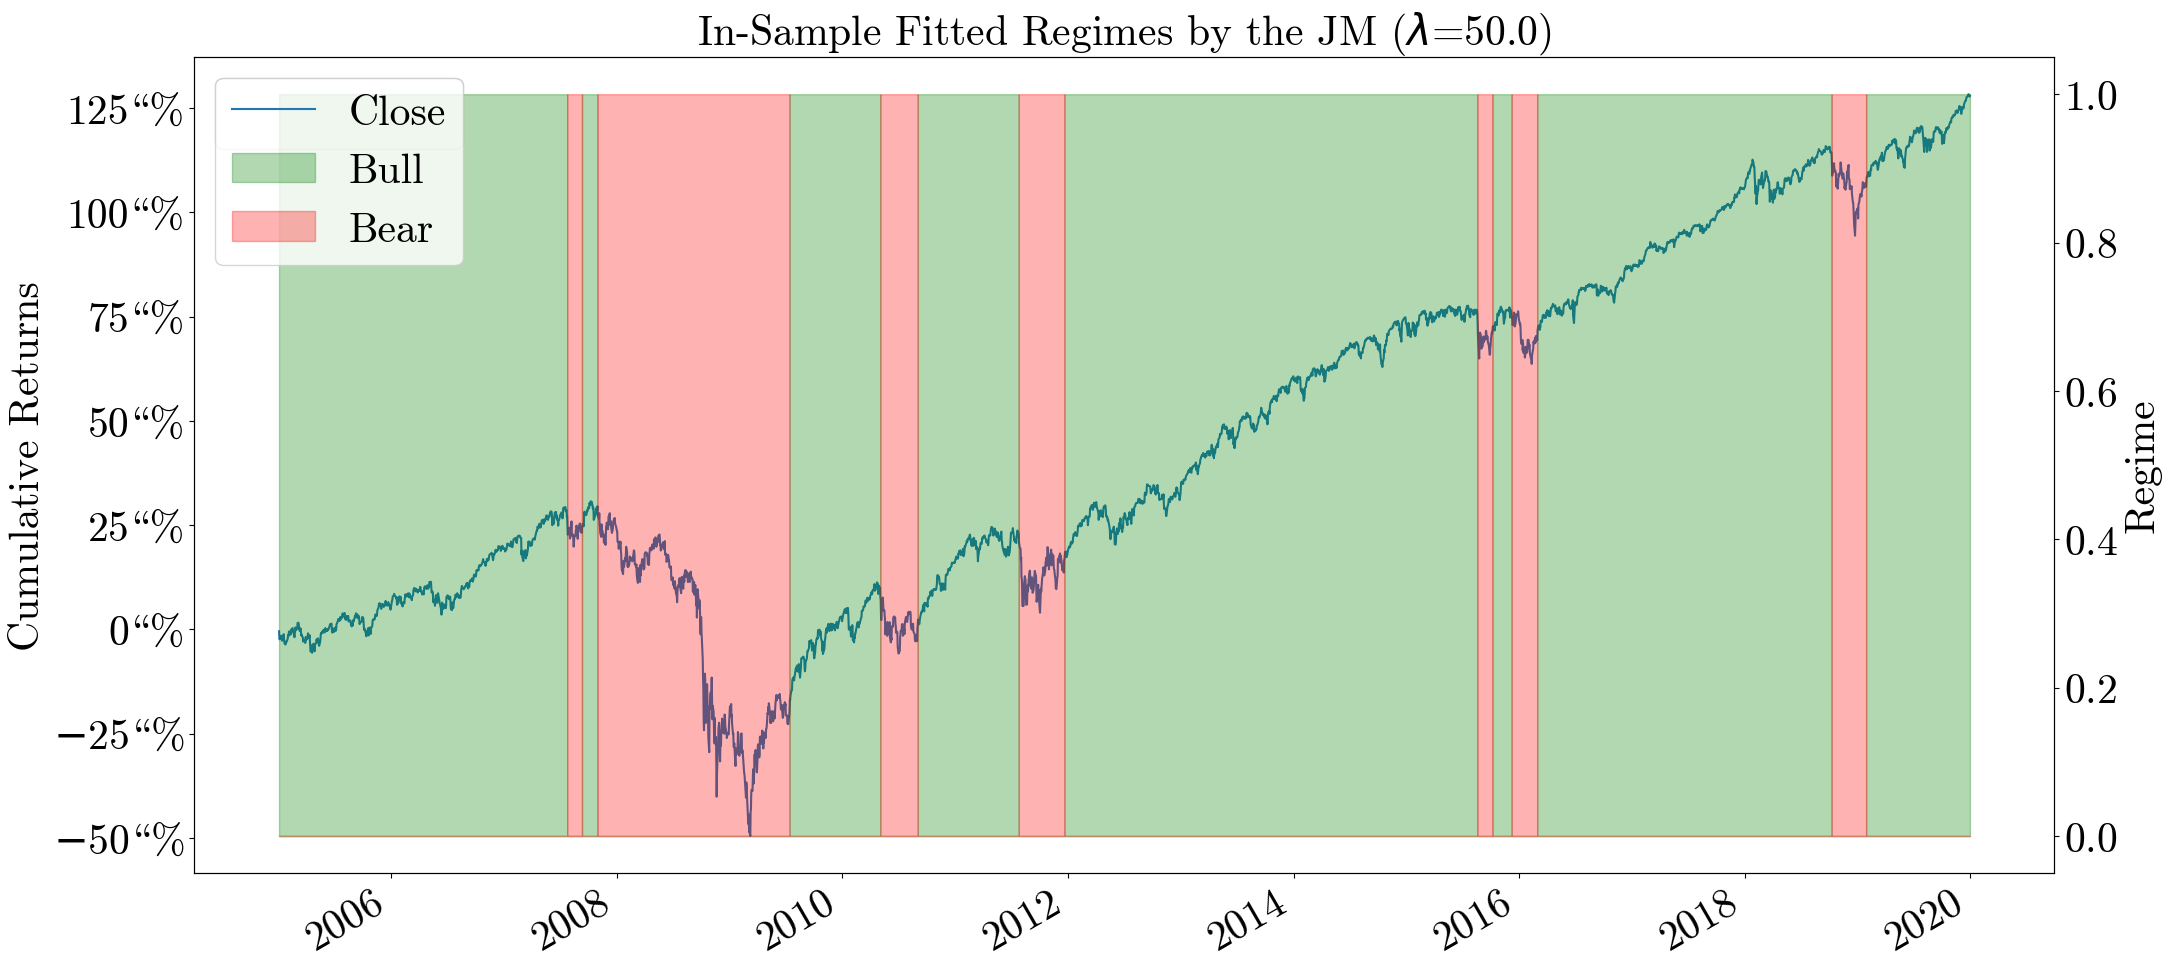

In [10]:
from jumpmodels.plot import plot_regimes_and_cumret, savefig_plt
# Plot regimes
ax, ax2 = plot_regimes_and_cumret(jm.labels_, log_ret, n_c=2, start_date=train_start, end_date=train_end)
ax.set(title=f"In-Sample Fitted Regimes by the JM ($\\lambda$={jump_penalty})")